In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/EEG

/content/drive/MyDrive/EEG


In [4]:
# !git clone https://github.com/tevisgehr/EEG-Classification.git

In [5]:
%cd /content/drive/My Drive/EEG/EEG-Classification

/content/drive/My Drive/EEG/EEG-Classification


In [6]:
from eeg_learn_functions import *

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import re
from numpy import genfromtxt

%matplotlib inline
plt.style.use('ggplot')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams["figure.figsize"] = (12,12)
pd.options.display.max_columns = None
pd.options.display.precision = 4

## Brainwave Frequencies:
Gamma, 30 to 50 Hz.  
Beta, 14 to 30 Hz.  
Alpha, 8 to 14 Hz.  
Theta, 4 to 8 Hz.  
Delta, 0.1 to 4 Hz.  

## Changing Bin Size: 
https://stackoverflow.com/questions/25735153/plotting-a-fast-fourier-transform-in-python  
(Search for 'bin')

An EEG processing library:  
https://github.com/pbashivan/EEGLearn

In [8]:
theta = (4,8)
alpha = (8,12)
beta = (12,40)

In [9]:
def get_fft(snippet):
    Fs = 128.0;  # sampling rate
    #Ts = len(snippet)/Fs/Fs; # sampling interval
    snippet_time = len(snippet)/Fs
    Ts = 1.0/Fs; # sampling interval
    t = np.arange(0,snippet_time,Ts) # time vector

    # ff = 5;   # frequency of the signal
    # y = np.sin(2*np.pi*ff*t)
    y = snippet
#     print('Ts: ',Ts)
#     print(t)
#     print(y.shape)
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(n//2)] # one side frequency range

    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(n//2)]
    #Added in: (To remove bias.)
    #Y[0] = 0
    return frq,abs(Y)
#f,Y = get_fft(np.hanning(len(snippet))*snippet)

In [10]:
def theta_alpha_beta_averages(f,Y):
    theta_range = (4,8)
    alpha_range = (8,12)
    beta_range = (12,40)
    theta = Y[(f>theta_range[0]) & (f<=theta_range[1])].mean()
    alpha = Y[(f>alpha_range[0]) & (f<=alpha_range[1])].mean()
    beta = Y[(f>beta_range[0]) & (f<=beta_range[1])].mean()
    return theta, alpha, beta

In [11]:
def make_steps(samples,frame_duration,overlap):
    '''
    in:
    samples - number of samples in the session
    frame_duration - frame duration in seconds 
    overlap - float fraction of frame to overlap in range (0,1)
    
    out: list of tuple ranges
    '''
    #steps = np.arange(0,len(df),frame_length)
    Fs = 128
    i = 0
    intervals = []
    samples_per_frame = Fs * frame_duration
    while i+samples_per_frame <= samples:
        intervals.append((i,i+samples_per_frame))
        i = i + samples_per_frame - int(samples_per_frame*overlap)
    return intervals

In [12]:
def make_frames(df,frame_duration):
    '''
    in: dataframe or array with all channels, frame duration in seconds
    out: array of theta, alpha, beta averages for each probe for each time step
        shape: (n-frames,m-probes,k-brainwave bands)
    '''
    Fs = 128.0
    frame_length = Fs*frame_duration
    frames = []
    steps = make_steps(len(df),frame_duration,overlap)
    for i,_ in enumerate(steps):
        frame = []
        if i == 0:
            continue
        else:
            for channel in df.columns:
                snippet = np.array(df.loc[steps[i][0]:steps[i][1],int(channel)])
                f,Y =  get_fft(snippet)
                theta, alpha, beta = theta_alpha_beta_averages(f,Y)
                frame.append([theta, alpha, beta])
            
        frames.append(frame)
    return np.array(frames)

In [13]:
locs_2d = [(-2.0,4.0),
           (2.0,4.0),
           (-1.0,3.0),
           (1.0,3.0),
           (-3.0,3.0),
           (3.0,3.0),
           (-2.0,2.0),
           (2.0,2.0),
           (-2.0,-2.0),
           (2.0,-2.0),
           (-4.0,1.0),
           (4.0,1.0),
           (-1.0,-3.0),
           (1.0,-3.0)]

In [14]:
def make_data_pipeline(file_names,labels,image_size,frame_duration,overlap):
    '''
    IN: 
    file_names - list of strings for each input file (one for each subject)
    labels - list of labels for each
    image_size - int size of output images in form (x, x)
    frame_duration - time length of each frame (seconds)
    overlap - float fraction of frame to overlap in range (0,1)
    
    OUT:
    X: np array of frames (unshuffled)
    y: np array of label for each frame (1 or 0)
    '''
    ##################################
    ###Still need to do the overlap###!!!
    ##################################
    
    Fs = 128.0   #sampling rate
    frame_length = Fs * frame_duration
    
    print('Generating training data...')
    
    
    for i, file in enumerate(file_names):
        print ('Processing session: ',file, '. (',i+1,' of ',len(file_names),')')
        data = genfromtxt(file, delimiter=',').T
        df = pd.DataFrame(data)
        
        X_0 = make_frames(df,frame_duration)
        #steps = np.arange(0,len(df),frame_length)
        X_1 = X_0.reshape(len(X_0),14*3)
        
        images = gen_images(np.array(locs_2d),X_1, image_size, normalize=False)
        images = np.swapaxes(images, 1, 3) 
        print(len(images), ' frames generated with label ', labels[i], '.')
        print('\n')
        if i == 0:
            X = images
            y = np.ones(len(images))*labels[0]
        else:
            X = np.concatenate((X,images),axis = 0)
            y = np.concatenate((y,np.ones(len(images))*labels[i]),axis = 0)
        
        
    return X,np.array(y)

In [15]:
# !unzip data_new.zip

In [16]:
file_names = ['data/ML101_KS.csv',
              'data/ML101_US.csv',
              'data/ML102_KS.csv',
              'data/ML102_US.csv',
              'data/ML103_KS.csv',
              'data/ML103_US.csv',
              'data/ML104_KS.csv',
              'data/ML104_US.csv',
              'data/ML105_KS.csv',
              'data/ML105_US.csv',
              'data/ML106_KS.csv',
              'data/ML106_US.csv',
              'data/ML107_KS.csv',
              'data/ML107_US.csv',
              'data/ML108_KS.csv',
              'data/ML108_US.csv', 
              'data_new/ML109_KS.csv',
              'data_new/ML109_US.csv',
              'data_new/ML110_KS.csv',
              'data_new/ML110_US.csv',
              'data_new/ML111_KS.csv',
              'data_new/ML111_US.csv',
              'data_new/ML112_KS.csv',
              'data_new/ML112_US.csv',
              'data_new/ML113_KS.csv',
              'data_new/ML113_US.csv',
              'data_new/ML114_KS.csv',
              'data_new/ML114_US.csv',
              'data_new/ML115_KS.csv',
              'data_new/ML115_US.csv',
              'data_new/ML116_KS.csv',
              'data_new/ML116_US.csv',
              'data_new/ML118_KS.csv',
              'data_new/ML118_US.csv',
              'data_new/ML119_KS.csv',
              'data_new/ML119_US.csv',
              'data_new/ML120_KS.csv',
              'data_new/ML120_US.csv',
              'data_new/ML121_KS.csv',
              'data_new/ML121_US.csv']
labels = [1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0]
image_size = 28
frame_duration = 1.0
overlap = 0.5
X, y = make_data_pipeline(file_names,labels,image_size,frame_duration,overlap)

Generating training data...
Processing session:  data/ML101_KS.csv . ( 1  of  40 )
234  frames generated with label  1 .


Processing session:  data/ML101_US.csv . ( 2  of  40 )
224  frames generated with label  0 .


Processing session:  data/ML102_KS.csv . ( 3  of  40 )
222  frames generated with label  1 .


Processing session:  data/ML102_US.csv . ( 4  of  40 )
218  frames generated with label  0 .


Processing session:  data/ML103_KS.csv . ( 5  of  40 )
226  frames generated with label  1 .


Processing session:  data/ML103_US.csv . ( 6  of  40 )
208  frames generated with label  0 .


Processing session:  data/ML104_KS.csv . ( 7  of  40 )
202  frames generated with label  1 .


Processing session:  data/ML104_US.csv . ( 8  of  40 )
204  frames generated with label  0 .


Processing session:  data/ML105_KS.csv . ( 9  of  40 )
214  frames generated with label  1 .


Processing session:  data/ML105_US.csv . ( 10  of  40 )
226  frames generated with label  0 .


Processing session:  

In [17]:
X.shape

(9283, 28, 28, 3)

In [18]:
y.shape

(9283,)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


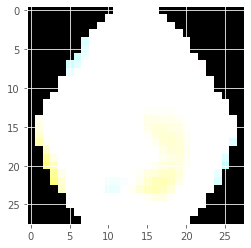

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X[0]);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


''

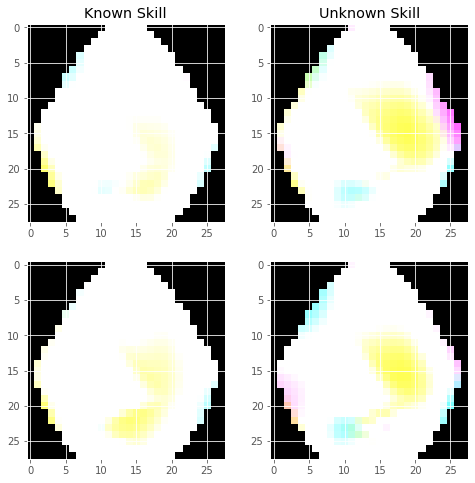

In [20]:
# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(2,2, figsize = (8,8))
axarr[0][0].set_title('Known Skill')
axarr[0][0].imshow(X[0])
axarr[1][0].imshow(X[1])

axarr[0][1].set_title('Unknown Skill')
axarr[0][1].imshow(X[20])
axarr[1][1].imshow(X[21])

;

In [21]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20,shuffle=True)

In [22]:
y_train.shape

(7426,)

In [23]:
# input image dimensions
img_rows, img_cols = 28, 28

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

input_shape = (img_rows, img_cols, 3)

x_train shape: (7426, 28, 28, 3)
7426 train samples
1857 test samples


In [24]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization

batch_size = 128
num_classes = 2
epochs = 400

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.30))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('tanh'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(lr=0.0007, decay=1e-5)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          shuffle=True)

Epoch 1/400
59/59 [==============================] - 1s 19ms/step - loss: 0.9928 - accuracy: 0.5158
Epoch 2/400
59/59 [==============================] - 1s 17ms/step - loss: 0.7078 - accuracy: 0.5338
Epoch 3/400
59/59 [==============================] - 1s 17ms/step - loss: 0.6973 - accuracy: 0.5494
Epoch 4/400
59/59 [==============================] - 1s 17ms/step - loss: 0.6848 - accuracy: 0.5681
Epoch 5/400
59/59 [==============================] - 1s 16ms/step - loss: 0.6727 - accuracy: 0.5897
Epoch 6/400
59/59 [==============================] - 1s 16ms/step - loss: 0.6644 - accuracy: 0.5900
Epoch 7/400
59/59 [==============================] - 1s 16ms/step - loss: 0.6530 - accuracy: 0.6204
Epoch 8/400
59/59 [==============================] - 1s 16ms/step - loss: 0.6467 - accuracy: 0.6169
Epoch 9/400
59/59 [==============================] - 1s 16ms/step - loss: 0.6263 - accuracy: 0.6407
Epoch 10/400
59/59 [==============================] - 1s 17ms/step - loss: 0.6215 - accuracy: 0.6457

### The training accuracy you see here, has gone as high as 98% but, our concern is always the test accuracy

### This is the test accuracy. 

In [25]:
y_pred= model.predict(x_test)

In [26]:
from sklearn.metrics import confusion_matrix, classification_report

In [27]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81       905
           1       0.81      0.84      0.83       952

    accuracy                           0.82      1857
   macro avg       0.82      0.82      0.82      1857
weighted avg       0.82      0.82      0.82      1857



### The f1 score is a parameter similar to accuracy but it tells us how good each class was predicted, and the prediction accuracy of both skilled and unskilles class is above 80 which is pretty good. 